# Thapar Summer School - Employee Salary Prediction

In this lab, we are predict the salaries of employee from different fake companies.

Here, the features are explain below:

- `id`: Identity of the employee
- `salary`: (Target Column) Salary of the employee
- `company`: Current Company of the employee
- `department`: Department of the employee
- `age`: Current age of the employee
- `age_when_joined`: Employee's age when joined the company
- `year_in_the_company`: Employee's experience in the company
- `prior_years_experiences`: Employee's experience prior to joining the company
- `annual_bonus`: Annual bonus of employee

## 1. Tools

Now, before we get, let's initialize some important's libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## 2. Viewing the data

Taking a look in our training dataset and getting more familiar with it. Remember that the training dataset and test dataset are already separated.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Looking at the first five examples of the dataset.

In [3]:
df_train.head()

,id,company,department,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,1,Cheerper,Support,40,36,4,69420.46872,22586.99591,2,0.000000,0.893809,0.328591
1,2,Cheerper,BigData,40,34,6,88407.04974,18676.07837,3,0.205947,0.756632,0.036870
2,3,Pear,Sales,41,39,2,97831.84885,19287.87365,2,0.942309,0.000000,0.514457
3,4,Glasses,Search Engine,39,33,6,93905.86813,17936.39297,3,0.484373,0.236922,0.278535
4,5,Glasses,AI,39,35,3,105983.97520,16854.92943,3,0.835346,0.308958,0.000000


Seeing the shape of our dataset.

In [4]:
n_rows = df_train.shape[0]
n_columns = df_train.shape[1]

print(f"The number of rows is: {n_rows}")
print(f"The number of columns is: {n_columns}")

The number of rows is: 100000
The number of columns is: 12


In [5]:
df_train.dtypes

id                          int64
company                    object
department                 object
age                         int64
age_when_joined             int64
years_in_the_company        int64
salary                    float64
annual_bonus              float64
prior_years_experience      int64
full_time                 float64
part_time                 float64
contractor                float64
dtype: object

Checking if the dataframe has some null value.

In [6]:
df_train.isnull().sum()

id                        0
company                   0
department                0
age                       0
age_when_joined           0
years_in_the_company      0
salary                    0
annual_bonus              0
prior_years_experience    0
full_time                 0
part_time                 0
contractor                0
dtype: int64

That's good. Now, we notice that just two features are categorical (`company` and `department`), while the others are numerical (without considerer `id`). Let's see the different values that each of the two feature contains.

#### Values in _company_ and _department_

In [7]:
df_train['company'].value_counts()

Glasses     47734
Cheerper    28583
Pear        23683
Name: company, dtype: int64

In [8]:
df_train['department'].value_counts()

Search Engine    21915
AI               21642
BigData          15777
Design           15713
Sales            12535
Support          12418
Name: department, dtype: int64

In [9]:
df_train.describe(include=object)

,company,department
count,100000,100000
unique,3,6
top,Glasses,Search Engine
freq,47734,21915


#### Summary measures of each numerical feature

In [10]:
df_train.describe(include=[int, float])

,id,age,age_when_joined,years_in_the_company,salary,annual_bonus,prior_years_experience,full_time,part_time,contractor
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,38.195870,33.537060,4.667780,87389.018245,18582.064815,2.505540,0.383531,0.383279,0.382016
std,28867.657797,6.013073,7.719078,2.531773,28478.542805,4373.431365,1.207222,0.340638,0.339783,0.339621
min,1.000000,30.000000,22.000000,1.000000,40000.000000,9000.000000,1.000000,0.000000,0.000000,0.000000
25%,25000.750000,33.000000,27.000000,3.000000,66027.961360,15448.885482,1.000000,0.016171,0.015702,0.013575
50%,50000.500000,38.000000,33.000000,5.000000,86554.204990,18821.651785,2.000000,0.333278,0.334739,0.331437
75%,75000.250000,43.000000,39.000000,7.000000,107269.920325,22168.522630,3.000000,0.653879,0.650733,0.649338
max,100000.000000,49.000000,48.000000,9.000000,153000.000000,24792.910000,5.000000,1.000000,1.000000,1.000000


For we will start the data pre-processing, we know that categorical features like **company** and **department** have a lower cardinality, which can be managed by some **encoding** techniques. 

Also, we know that the others features (which are numerical) are having **high deviation** values which can lead to bias, overfitting, and can affect the accuracy of the model. So, we can use some different transformation techniques to reduce the deviation between the data-points.

## Exploratory Data Analysis

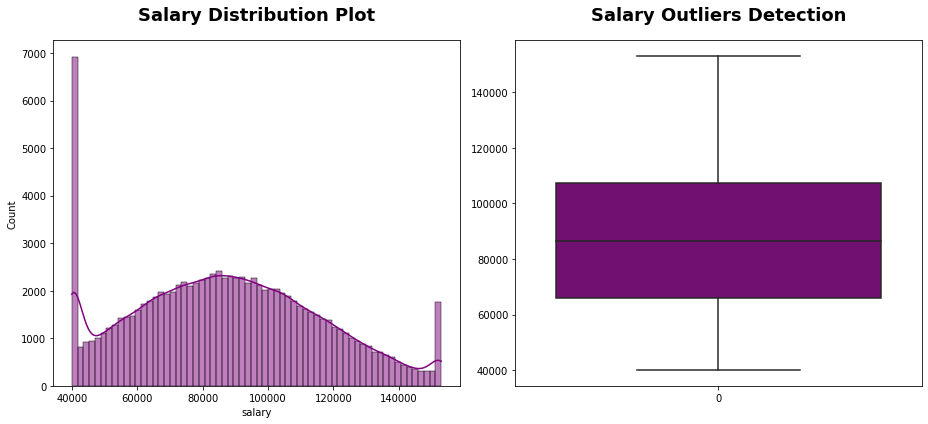

In [11]:
plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
sns.histplot(df_train["salary"],color="purple",kde=True)
plt.title("Salary Distribution Plot",fontweight="black",pad=20,size=18)

plt.subplot(1,2,2)
sns.boxplot(df_train["salary"],color="purple")
plt.title("Salary Outliers Detection",fontweight="black",pad=20,size=18)
plt.tight_layout()
plt.show()

In [12]:
df_train.salary.describe()

count    100000.000000
mean      87389.018245
std       28478.542805
min       40000.000000
25%       66027.961360
50%       86554.204990
75%      107269.920325
max      153000.000000
Name: salary, dtype: float64

## 3. Data pre-processing

Notice that the column `id` only represents the _index_ of a employee. So, as it appears to be irrelevant to analysis, we can simply **drop the feature**.

In [13]:
df_train = df_train.drop(columns='id')

#### Separating numerical features and categorical features

In [14]:
# taking only numerical features
num_feat = df_train.drop(columns=['company', 'department', 'salary'])

# taking only categorical features
cat_feat = df_train.loc[:, ['company', 'department']]

#### Processing the categorical features using OneHotEnconder

In [15]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# label encoded values of company and department
enc_df = pd.DataFrame(enc.fit_transform(cat_feat[['company', 'department']]).toarray(), columns=enc.get_feature_names(['company', 'department']))
enc_df.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Feature scaling using StandardScale

Notice that, for example, the numerical feature `annual_bonus` have a large scale of values, so, as not to affect the performance of the model and avoid convergence problems for models based on gradients.

In [16]:
# creating a instance of StandardScaler
scaler = StandardScaler()

# applying StandardScaler only to features
num_feat_norm = scaler.fit_transform(num_feat)

# converting normalized output to a new DataFrame
feat_norm_df = pd.DataFrame(num_feat_norm, columns=num_feat.columns)
feat_norm_df.head()

,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308
1,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274
2,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967
3,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698
4,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837


Taking only the target `salary` of dataframe `df_train` to concat with the others df's.

In [17]:
# taking the target
target_df = df_train.loc[:,'salary']

# concatenating the df's of preprocessed numerical and categorical features
all_features = pd.concat([enc_df, feat_norm_df], axis=1)

# concatening the df's of all features with the target
df_train = pd.concat([all_features, target_df], axis=1)
df_train.head()

,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor,salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.300036,0.319073,-0.263761,0.915746,-0.418765,-1.125925,1.502528,-0.157308,69420.46872
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300036,0.059974,0.526203,0.021497,0.409587,-0.521329,1.098805,-1.016274,88407.04974
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.466341,0.707723,-1.053725,0.161386,-0.418765,1.640396,-1.128018,0.389967,97831.84885
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.133731,-0.069576,0.526203,-0.147636,0.409587,0.296040,-0.430738,-0.304698,93905.86813
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.133731,0.189524,-0.658743,-0.394917,0.409587,1.326385,-0.218732,-1.124837,105983.97520


In [18]:
df_train.shape

(100000, 18)

In [19]:
df_train.dtypes

company_Cheerper            float64
company_Glasses             float64
company_Pear                float64
department_AI               float64
department_BigData          float64
department_Design           float64
department_Sales            float64
department_Search Engine    float64
department_Support          float64
age                         float64
age_when_joined             float64
years_in_the_company        float64
annual_bonus                float64
prior_years_experience      float64
full_time                   float64
part_time                   float64
contractor                  float64
salary                      float64
dtype: object

#### Separating X_train | y_train and X_cv | y_cv

Today, we know that there are a variety of regression algorithms and a instead to put our focus in only one of those algorithms, it's would be better have some other dataset to realize a cross validation and use them to evaluate different configurations of model. With that, we be able to choose the better model through some metrics like R2 Score and some error functions.

In [20]:
feat_train, targ_train = df_train.drop(columns='salary'), df_train.loc[:, 'salary']
X_train, X_cv, y_train, y_cv = train_test_split(feat_train, targ_train, test_size=0.2, random_state=0)

In [21]:
print("Dimension of X_train =>", X_train.shape)
print("Dimension of X_cv =>", X_cv.shape)
print("Dimension of y_train =>", y_train.shape)
print("Dimension of y_cv =>", y_cv.shape)

Dimension of X_train => (80000, 17)
Dimension of X_cv => (20000, 17)
Dimension of y_train => (80000,)
Dimension of y_cv => (20000,)


#### Doing all preprocessing to the df of the test and obtaining X_test

In [22]:
# drop id
df_test = df_test.drop(columns='id')

# separate the numerical features and categorical features
num_feat_test = df_test.drop(columns=['company', 'department'])
cat_feat_test = df_test.loc[:, ['company', 'department']]

# OneHotEncoder
enc_test = OneHotEncoder(handle_unknown='ignore')
enc_test_df = pd.DataFrame(enc_test.fit_transform(cat_feat_test[['company', 'department']]).toarray(), columns=enc_test.get_feature_names(['company', 'department']))

# Feature scaling
num_feat_norm_test = scaler.fit_transform(num_feat_test)
feat_norm_df_test = pd.DataFrame(num_feat_norm_test, columns=num_feat_test.columns)

# concatenating the df's of preprocessed numerical and categorical features of test
X_test = pd.concat([enc_test_df, feat_norm_df_test], axis=1)
X_test.head()

C:\Users\samue\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,company_Cheerper,company_Glasses,company_Pear,department_AI,department_BigData,department_Design,department_Sales,department_Search Engine,department_Support,age,age_when_joined,years_in_the_company,annual_bonus,prior_years_experience,full_time,part_time,contractor
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.117167,1.859593,-1.442821,-2.176168,1.239771,-1.127529,-0.653535,1.811299
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.452452,1.083241,-1.442821,-0.367324,1.239771,0.254885,-1.126316,0.999501
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.876979,-1.375206,1.718193,-0.898164,1.239771,-0.129338,1.118517,-1.129061
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.710800,-0.598855,0.137686,0.977069,-0.415398,1.799037,-1.126316,0.075396
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.618631,0.953849,-1.442821,-0.665359,-0.415398,-1.127529,0.997430,0.616834


## 4. Model Creation & Evaluation

We will create a function to train model using different regression algorithms.

In [23]:
r2_value = []
adjusted_r2_value = []
mae_value = []
mse_value = []
rmse_value = []

In [24]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_train_pred= model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    #Metrics Calculation.
    mae = mean_absolute_error(y_cv,y_cv_pred)
    mse = mean_squared_error(y_cv,y_cv_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_cv,y_cv_pred)
    adjusted_r2 = 1 - ((1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
   
    mae_value.append(mae)
    mse_value.append(mse)
    rmse_value.append(rmse)
    r2_value.append(r2)
    adjusted_r2_value.append(adjusted_r2) 
    
    print(f"R2 Score of the {model} model is=>",r2)
    print(f"Adjusted R2 Score of the {model} model is=>",adjusted_r2)
    print()
    print(f"MAE of {model} model is=>",mae)
    print(f"MSE of {model} model is=>",mse)
    print(f"RMSE of {model} model is=>",rmse)
    

    # Scatter plot.
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)    
    plt.scatter(y_train, y_train_pred, color='blue', label='Train')
    plt.scatter(y_cv, y_cv_pred, color='red', label='Test')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.title('Scatter Plot',fontweight="black",size=20,pad=10)
    
    # Residual plot.
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', label='Train')
    plt.scatter(y_cv_pred, y_cv_pred - y_cv, color='red', label='Test')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title('Residual Plot',fontweight="black",size=20,pad=10)
    plt.show()

#### Creating a LinearRegression Model

R2 Score of the LinearRegression() model is=> 0.6887394442129928
Adjusted R2 Score of the LinearRegression() model is=> 0.6886335775120129

MAE of LinearRegression() model is=> 12731.300194108499
MSE of LinearRegression() model is=> 251835239.21168736
RMSE of LinearRegression() model is=> 15869.317540829768


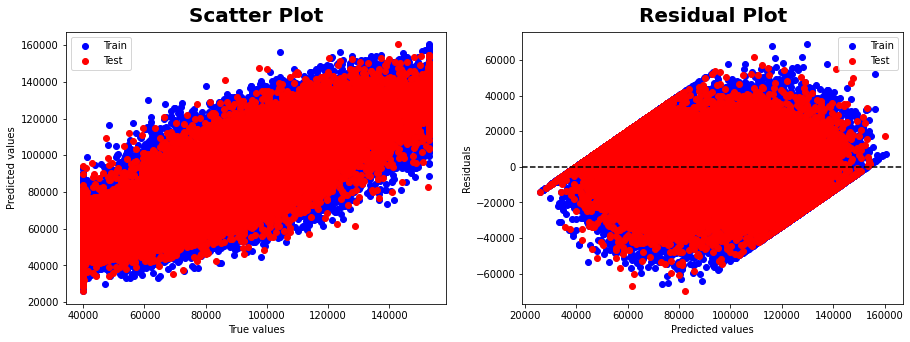

In [25]:
model_evaluation(LinearRegression())

#### Creating a SGDRegressor Model

R2 Score of the SGDRegressor() model is=> 0.688565193124191
Adjusted R2 Score of the SGDRegressor() model is=> 0.6884592671565049

MAE of SGDRegressor() model is=> 12746.061396762088
MSE of SGDRegressor() model is=> 251976222.5898105
RMSE of SGDRegressor() model is=> 15873.758930694723


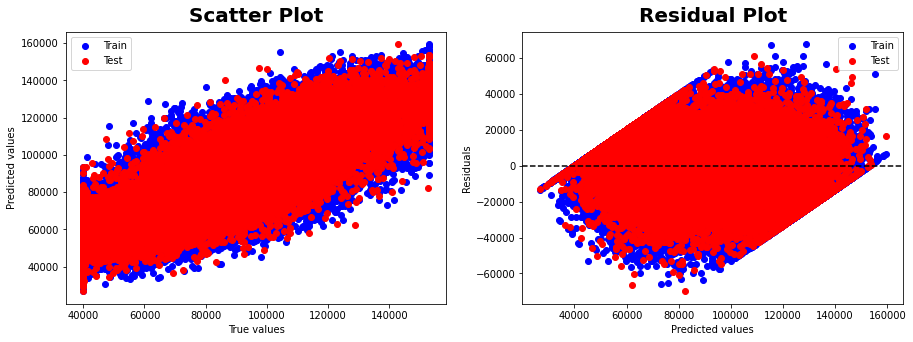

In [26]:
model_evaluation(SGDRegressor(max_iter=1000))

#### Creating a GradientBoostingRegressor Model

R2 Score of the GradientBoostingRegressor() model is=> 0.7143994135459177
Adjusted R2 Score of the GradientBoostingRegressor() model is=> 0.7143022743764224

MAE of GradientBoostingRegressor() model is=> 12237.214099012463
MSE of GradientBoostingRegressor() model is=> 231074225.98666552
RMSE of GradientBoostingRegressor() model is=> 15201.125813131917


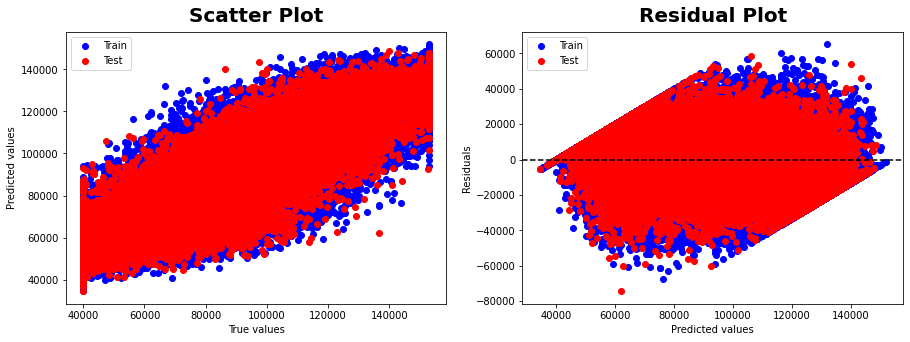

In [27]:
model_evaluation(GradientBoostingRegressor())

#### Creating a RandomForestRegressor Model

R2 Score of the RandomForestRegressor() model is=> 0.705701131026015
Adjusted R2 Score of the RandomForestRegressor() model is=> 0.7056010333754096

MAE of RandomForestRegressor() model is=> 12289.814609741681
MSE of RandomForestRegressor() model is=> 238111847.7424704
RMSE of RandomForestRegressor() model is=> 15430.873200907019


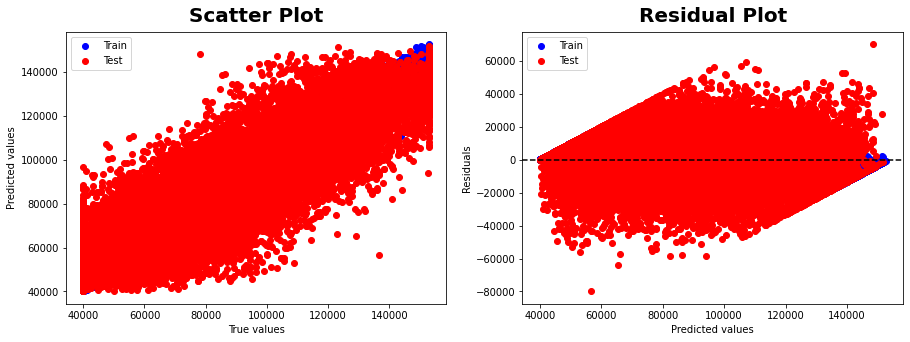

In [28]:
model_evaluation(RandomForestRegressor())

####  Creating a AdaBoostRegressor Model

R2 Score of the AdaBoostRegressor() model is=> 0.6129257502364905
Adjusted R2 Score of the AdaBoostRegressor() model is=> 0.6127940975966206

MAE of AdaBoostRegressor() model is=> 14480.81648412268
MSE of AdaBoostRegressor() model is=> 313174716.38964045
RMSE of AdaBoostRegressor() model is=> 17696.74310119352


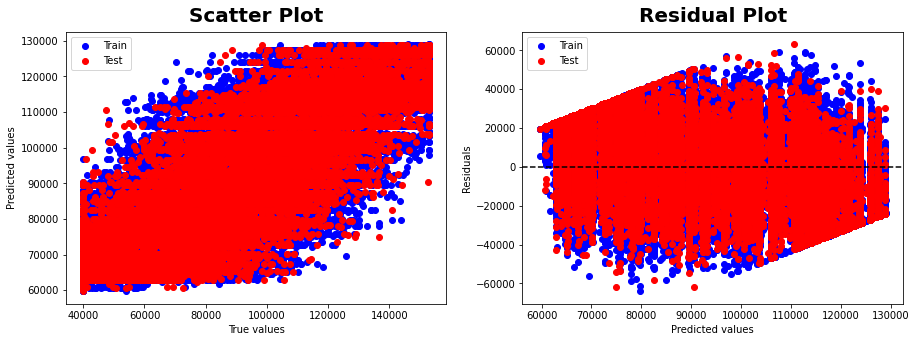

In [29]:
model_evaluation(AdaBoostRegressor())

#### Creating a XGBRegressor Model

R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model is=> 0.7281828862995113
Adjusted R2 Score of the XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
    

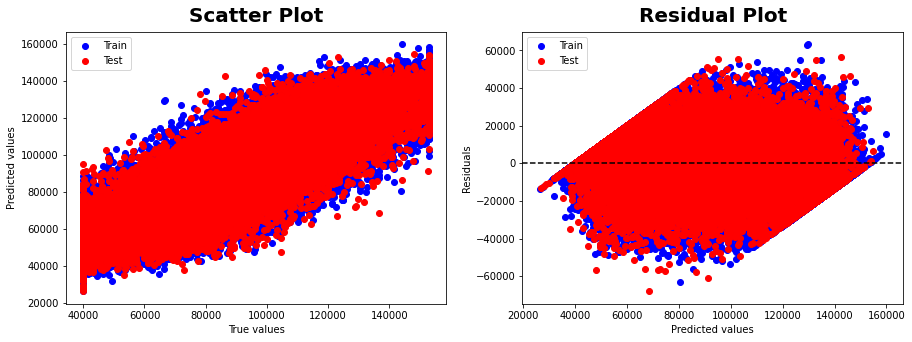

In [30]:
model_evaluation(XGBRegressor())

#### Creating a CatBoostRegressor Model

Learning rate set to 0.081822
0:	learn: 27116.4010602	total: 155ms	remaining: 2m 35s
1:	learn: 25890.4528910	total: 161ms	remaining: 1m 20s
2:	learn: 24786.9983415	total: 168ms	remaining: 55.7s
3:	learn: 23814.7750117	total: 174ms	remaining: 43.3s
4:	learn: 22934.2813062	total: 179ms	remaining: 35.7s
5:	learn: 22148.7043883	total: 186ms	remaining: 30.7s
6:	learn: 21437.0793642	total: 192ms	remaining: 27.2s
7:	learn: 20816.7429297	total: 198ms	remaining: 24.6s
8:	learn: 20281.4416094	total: 204ms	remaining: 22.5s
9:	learn: 19799.2674840	total: 210ms	remaining: 20.8s
10:	learn: 19376.3058853	total: 216ms	remaining: 19.5s
11:	learn: 18987.4473681	total: 223ms	remaining: 18.4s
12:	learn: 18649.1678429	total: 229ms	remaining: 17.4s
13:	learn: 18369.2924471	total: 236ms	remaining: 16.6s
14:	learn: 18105.5529317	total: 242ms	remaining: 15.9s
15:	learn: 17863.4663226	total: 248ms	remaining: 15.3s
16:	learn: 17659.5785258	total: 255ms	remaining: 14.7s
17:	learn: 17486.1903435	total: 260ms	remai

184:	learn: 14623.1254700	total: 1.06s	remaining: 4.69s
185:	learn: 14621.4349005	total: 1.07s	remaining: 4.68s
186:	learn: 14619.1755036	total: 1.07s	remaining: 4.68s
187:	learn: 14617.0246458	total: 1.08s	remaining: 4.67s
188:	learn: 14614.7431263	total: 1.08s	remaining: 4.66s
189:	learn: 14612.1296856	total: 1.09s	remaining: 4.65s
190:	learn: 14609.8244481	total: 1.09s	remaining: 4.64s
191:	learn: 14607.7595438	total: 1.1s	remaining: 4.63s
192:	learn: 14605.3989697	total: 1.1s	remaining: 4.61s
193:	learn: 14603.4703811	total: 1.11s	remaining: 4.6s
194:	learn: 14601.2738609	total: 1.11s	remaining: 4.59s
195:	learn: 14599.2694511	total: 1.12s	remaining: 4.58s
196:	learn: 14597.4340190	total: 1.12s	remaining: 4.57s
197:	learn: 14595.7666507	total: 1.13s	remaining: 4.56s
198:	learn: 14594.1963056	total: 1.13s	remaining: 4.55s
199:	learn: 14592.6885529	total: 1.14s	remaining: 4.55s
200:	learn: 14590.8587654	total: 1.14s	remaining: 4.54s
201:	learn: 14588.7063940	total: 1.15s	remaining: 4

355:	learn: 14385.8439478	total: 1.96s	remaining: 3.54s
356:	learn: 14384.7791600	total: 1.96s	remaining: 3.54s
357:	learn: 14383.7625773	total: 1.97s	remaining: 3.53s
358:	learn: 14382.8083845	total: 1.98s	remaining: 3.53s
359:	learn: 14382.1238520	total: 1.98s	remaining: 3.52s
360:	learn: 14381.0761334	total: 1.99s	remaining: 3.51s
361:	learn: 14380.1254531	total: 1.99s	remaining: 3.51s
362:	learn: 14378.7405442	total: 2s	remaining: 3.5s
363:	learn: 14377.6462277	total: 2s	remaining: 3.5s
364:	learn: 14376.4679514	total: 2.01s	remaining: 3.49s
365:	learn: 14375.5723701	total: 2.01s	remaining: 3.48s
366:	learn: 14374.9073144	total: 2.02s	remaining: 3.48s
367:	learn: 14373.9454635	total: 2.02s	remaining: 3.47s
368:	learn: 14373.0469200	total: 2.02s	remaining: 3.46s
369:	learn: 14371.7483698	total: 2.03s	remaining: 3.46s
370:	learn: 14370.7133484	total: 2.03s	remaining: 3.45s
371:	learn: 14369.6072818	total: 2.04s	remaining: 3.44s
372:	learn: 14368.4732151	total: 2.04s	remaining: 3.44s


528:	learn: 14241.6180749	total: 2.85s	remaining: 2.54s
529:	learn: 14240.8580291	total: 2.86s	remaining: 2.53s
530:	learn: 14239.8066969	total: 2.86s	remaining: 2.53s
531:	learn: 14239.1892431	total: 2.87s	remaining: 2.52s
532:	learn: 14238.4975647	total: 2.87s	remaining: 2.52s
533:	learn: 14237.5424050	total: 2.88s	remaining: 2.51s
534:	learn: 14236.9250747	total: 2.88s	remaining: 2.51s
535:	learn: 14236.0537958	total: 2.89s	remaining: 2.5s
536:	learn: 14235.5585587	total: 2.89s	remaining: 2.5s
537:	learn: 14234.6040744	total: 2.9s	remaining: 2.49s
538:	learn: 14233.9456993	total: 2.9s	remaining: 2.48s
539:	learn: 14232.9632856	total: 2.91s	remaining: 2.48s
540:	learn: 14232.2971505	total: 2.91s	remaining: 2.47s
541:	learn: 14231.3503165	total: 2.92s	remaining: 2.46s
542:	learn: 14230.8300091	total: 2.92s	remaining: 2.46s
543:	learn: 14230.2607478	total: 2.93s	remaining: 2.45s
544:	learn: 14229.4758916	total: 2.93s	remaining: 2.45s
545:	learn: 14228.6147887	total: 2.94s	remaining: 2.

697:	learn: 14126.0648354	total: 3.75s	remaining: 1.62s
698:	learn: 14125.4663939	total: 3.75s	remaining: 1.62s
699:	learn: 14124.7643336	total: 3.76s	remaining: 1.61s
700:	learn: 14124.0907202	total: 3.76s	remaining: 1.6s
701:	learn: 14123.3399048	total: 3.77s	remaining: 1.6s
702:	learn: 14122.9088686	total: 3.77s	remaining: 1.59s
703:	learn: 14122.1777370	total: 3.78s	remaining: 1.59s
704:	learn: 14121.3461047	total: 3.79s	remaining: 1.58s
705:	learn: 14120.6790641	total: 3.79s	remaining: 1.58s
706:	learn: 14119.9701613	total: 3.8s	remaining: 1.57s
707:	learn: 14119.2629451	total: 3.81s	remaining: 1.57s
708:	learn: 14118.6757561	total: 3.81s	remaining: 1.56s
709:	learn: 14118.3785707	total: 3.82s	remaining: 1.56s
710:	learn: 14117.6524693	total: 3.82s	remaining: 1.55s
711:	learn: 14117.0411524	total: 3.83s	remaining: 1.55s
712:	learn: 14116.3173110	total: 3.83s	remaining: 1.54s
713:	learn: 14115.7315670	total: 3.84s	remaining: 1.54s
714:	learn: 14115.2258621	total: 3.84s	remaining: 1

879:	learn: 14012.4956068	total: 4.64s	remaining: 633ms
880:	learn: 14011.8860809	total: 4.65s	remaining: 628ms
881:	learn: 14011.1420021	total: 4.65s	remaining: 623ms
882:	learn: 14010.3459564	total: 4.66s	remaining: 617ms
883:	learn: 14009.8407686	total: 4.66s	remaining: 612ms
884:	learn: 14009.4846436	total: 4.67s	remaining: 607ms
885:	learn: 14009.0661127	total: 4.67s	remaining: 602ms
886:	learn: 14008.6626564	total: 4.68s	remaining: 596ms
887:	learn: 14008.1241555	total: 4.68s	remaining: 591ms
888:	learn: 14007.6399308	total: 4.69s	remaining: 586ms
889:	learn: 14007.0324189	total: 4.69s	remaining: 580ms
890:	learn: 14006.5850777	total: 4.7s	remaining: 575ms
891:	learn: 14005.8858569	total: 4.7s	remaining: 570ms
892:	learn: 14005.1733043	total: 4.71s	remaining: 564ms
893:	learn: 14004.6583335	total: 4.71s	remaining: 559ms
894:	learn: 14003.8972852	total: 4.72s	remaining: 554ms
895:	learn: 14003.2888594	total: 4.72s	remaining: 548ms
896:	learn: 14002.4007742	total: 4.73s	remaining: 

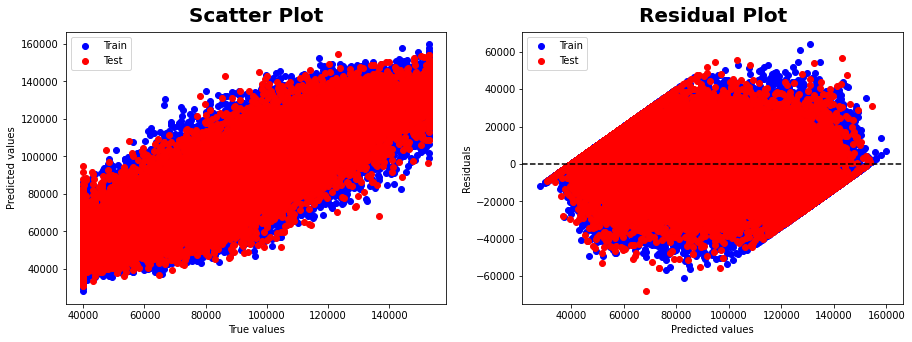

In [31]:
model_evaluation(CatBoostRegressor())

#### Creating a Neural Network Model

In [32]:
X_train.keys()

Index(['company_Cheerper', 'company_Glasses', 'company_Pear', 'department_AI',
       'department_BigData', 'department_Design', 'department_Sales',
       'department_Search Engine', 'department_Support', 'age',
       'age_when_joined', 'years_in_the_company', 'annual_bonus',
       'prior_years_experience', 'full_time', 'part_time', 'contractor'],
      dtype='object')

In [33]:
# creating a network
def build_model():
    model = Sequential([
    Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
  ])
    # We will use a mean squared error loss and an Adam optimizer.
    optimizer = tf.keras.optimizers.Adam(0.005)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,785
Trainable params: 14,785
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Shows training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

# The patience parameter is the number of epochs to check the improvements
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Epoch 1/100
2000/2000 [==============================] - 3s 1ms/step - loss: 517351904.0000 - mae: 15385.4199 - mse: 517351904.0000 - val_loss: 245670352.0000 - val_mae: 12578.7354 - val_mse: 245670352.0000
Epoch 2/100
2000/2000 [==============================] - 2s 954us/step - loss: 245063856.0000 - mae: 12542.6982 - mse: 245063856.0000 - val_loss: 237688848.0000 - val_mae: 12346.3721 - val_mse: 237688848.0000
Epoch 3/100
2000/2000 [==============================] - 2s 984us/step - loss: 238911648.0000 - mae: 12384.5225 - mse: 238911648.0000 - val_loss: 235338096.0000 - val_mae: 12230.9873 - val_mse: 235338096.0000
Epoch 4/100
2000/2000 [==============================] - 2s 917us/step - loss: 235048016.0000 - mae: 12266.7168 - mse: 235048016.0000 - val_loss: 230218512.0000 - val_mae: 12099.5742 - val_mse: 230218512.0000
Epoch 5/100
2000/2000 [==============================] - 2s 917us/step - loss: 232982240.0000 - mae: 12195.8740 - mse: 232982240.0000 - val_loss: 231325568.0000 - val

2000/2000 [==============================] - 2s 967us/step - loss: 220028448.0000 - mae: 11829.1289 - mse: 220028448.0000 - val_loss: 219715392.0000 - val_mae: 11816.8672 - val_mse: 219715392.0000
Epoch 40/100
2000/2000 [==============================] - 2s 969us/step - loss: 219454064.0000 - mae: 11820.3311 - mse: 219454064.0000 - val_loss: 221197648.0000 - val_mae: 11832.0420 - val_mse: 221197648.0000
Epoch 41/100
2000/2000 [==============================] - 2s 975us/step - loss: 219382656.0000 - mae: 11829.6406 - mse: 219382656.0000 - val_loss: 230316736.0000 - val_mae: 12036.1152 - val_mse: 230316736.0000
Epoch 42/100
2000/2000 [==============================] - 2s 957us/step - loss: 219133088.0000 - mae: 11807.3086 - mse: 219133088.0000 - val_loss: 219878352.0000 - val_mae: 11798.2031 - val_mse: 219878352.0000
Epoch 43/100
2000/2000 [==============================] - 2s 945us/step - loss: 218873952.0000 - mae: 11806.7236 - mse: 218873952.0000 - val_loss: 218423600.0000 - val_mae: 

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
38,220028448.0,11829.128906,220028448.0,219715392.0,11816.867188,219715392.0,38
39,219454064.0,11820.331055,219454064.0,221197648.0,11832.041992,221197648.0,39
40,219382656.0,11829.640625,219382656.0,230316736.0,12036.115234,230316736.0,40
41,219133088.0,11807.308594,219133088.0,219878352.0,11798.203125,219878352.0,41
42,218873952.0,11806.723633,218873952.0,218423600.0,11764.534180,218423600.0,42


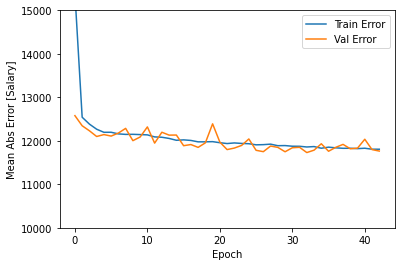

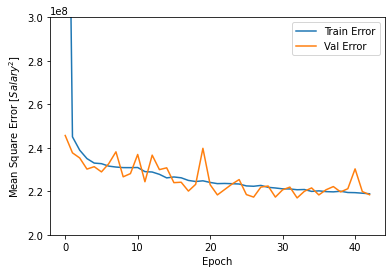

In [36]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Salary]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([1e4,1.5e4])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Salary^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([2e8,3e8])
    plt.legend()
    plt.show()


plot_history(history)